In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

dataset_folder = '/content/gdrive/My Drive/Colab Notebooks/graph_dataset'


In [ ]:
!pip install torchmetrics
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu115.html
!pip install class_resolver

In [ ]:
#@title Constants

SENTENCE_EMB = 1
TOKEN_EMB = 2

INTERACTION_CLASSES = {'negative', 'advise', 'effect', 'mechanism', 'int'}
TOKEN_CLASS = 'Token'
SENT_CLASS = 'Sentence'
RDF_TYPE = 'rdf_type'
RDF_S = 'rdf_subject'
RDF_P = 'rdf_predicate'
RDF_O = 'rdf_object'
DOMAIN = 'rdfs_domain'
RANGE = 'rdfs_range'
DRUG_CLASS = 'Drug_Class'
SAME_AS = 'owl_sameAs'
INTERACTION_CLASS = 'Interaction'

SENT_SOURCE = 'source'
ENT_FOUND_AS = 'found_as'
INT_FOUND = 'interaction_found'
SENT_CON_INTER = 'contains_interaction'
SENT_CON_TOKEN = 'contains_token'
SENT_DOC = 'document'
WITH_TOKEN = 'with_token'
TOKEN_IN_INT = 'in_interaction'



DOMAIN_RANGE = {
    ENT_FOUND_AS :      {DOMAIN: DRUG_CLASS,        RANGE: TOKEN_CLASS},
    INT_FOUND:          {DOMAIN: DRUG_CLASS,        RANGE: INTERACTION_CLASS},
    SAME_AS:            {DOMAIN: DRUG_CLASS,        RANGE: DRUG_CLASS},
    SENT_CON_INTER:     {DOMAIN: SENT_CLASS,        RANGE: INTERACTION_CLASS},
    SENT_CON_TOKEN:     {DOMAIN: SENT_CLASS,        RANGE: TOKEN_CLASS},

    TOKEN_IN_INT:       {DOMAIN: TOKEN_CLASS,       RANGE: INTERACTION_CLASS},
    WITH_TOKEN:         {DOMAIN: INTERACTION_CLASS, RANGE: TOKEN_CLASS},
    SENT_SOURCE:        {DOMAIN: INTERACTION_CLASS, RANGE: SENT_CLASS}
}

INVERSE = {
    SENT_SOURCE:    SENT_CON_INTER,
    SENT_CON_INTER: SENT_SOURCE,

    WITH_TOKEN:     TOKEN_IN_INT,
    TOKEN_IN_INT:   WITH_TOKEN
}


def get_domain_range(predicate):
    try:
        dr = DOMAIN_RANGE[predicate]
        return dr[DOMAIN], dr[RANGE]
    except KeyError:
        return None, None

def get_inverse(predicate):
    return INVERSE.get(predicate, None)


In [ ]:
#@title Imports


import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn
import torchmetrics
from torchmetrics import ConfusionMatrix
from torch.nn.functional import softmax
from torch.nn import Dropout
from torch.nn.functional import dropout
from torch import tanh
from torch.nn.functional import leaky_relu, relu


import torch_geometric
from torch_geometric.utils import dropout_adj
from torch_geometric.nn import Linear

from torch_geometric.data import HeteroData, Dataset
from torch_geometric.loader import HGTLoader
from torch_geometric.transforms import RandomNodeSplit

from torch_geometric.nn.models import MLP
from torch_geometric.nn import SAGEConv, GINConv, GATConv, GCNConv, BatchNorm, HeteroConv


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


import json
from os.path import exists



pd.set_option('display.width', 500)
pd.set_option("display.max_rows", None, "display.max_columns", None)



def set_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)

    torch_geometric.seed_everything(0)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


def device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


def graph_dataset(train):
    return dataset_folder + ('/train' if train else '/test')




In [ ]:
#@title Load word embeddings 

class WordEmbeddings:

    def __init__(self, train, sentences_init=None):

        self.sentence_emb_file = WordEmbeddings.embeddings_file_path(train, SENTENCE_EMB)
        self.token_emb_file    = WordEmbeddings.embeddings_file_path(train, TOKEN_EMB)
        self.files_exist       = exists(self.sentence_emb_file) and exists(self.token_emb_file)
        if not self.files_exist:
            if sentences_init is None:
                raise Exception('Files not found and sentence_init arg eq to None')


    @staticmethod
    def get_embbedings_files(train):
        return [WordEmbeddings.embeddings_file_path(train, SENTENCE_EMB),
                WordEmbeddings.embeddings_file_path(train, TOKEN_EMB)]


    @staticmethod
    def embeddings_file_path(train, embeddings_mode):
        return graph_dataset(train) + '/raw/' + \
            ('sentence' if embeddings_mode == SENTENCE_EMB else 'token')\
            + '_embeddings.pt'


    def word_embeddings(self):

        embeddings = {}
        for (file, embeddings_mode) in [(self.sentence_emb_file, SENTENCE_EMB), (self.token_emb_file, TOKEN_EMB)]:

            embeddings[embeddings_mode] = \
                        torch.load(file) if self.files_exist \
                        else None

        return embeddings[SENTENCE_EMB], embeddings[TOKEN_EMB]


In [ ]:

#@title Graph Dataset


ZERO_INIT = 0


class GraphDataset(Dataset):

    def __init__(self, train, add_inverse=False):
        self.train = train
        self.f = self.set_files()
        self.label_enc = LabelEncoder().fit(list(INTERACTION_CLASSES))
        self.negative_label = self.label_enc.transform(['negative'])[0]

        super(GraphDataset, self).__init__(root=graph_dataset(self.train), transform=None)

        if add_inverse:
            self.add_inverse_edges()


# -----------------------------------------------------------------------------------------------------------------------

    def set_files(self):
        files = {}
        path = graph_dataset(self.train)
        files['processed_path'] = path + '/processed'
        files['saved_dataset'] = f"{files['processed_path']}/dataset.pt"
        files['dataset_info'] = f"{files['processed_path']}/dataset_info.data"
        files['files'] = [files['saved_dataset'], files['dataset_info']]

        return files

    @property
    def raw_file_names(self):
        """
        Τα αρχεία που πρέπει να είναι αποθηκευμένα ώστε να μη χρειαστεί να τα φτιάξει
        """
        return self.f['files']

    def download(self):
        pass


    def save_dataset(self):
        if not exists(self.f['processed_path']):
            mkdir(self.f['processed_path'])
        torch.save(self.graph, self.f['saved_dataset'])
        dataset_info = {'n_interaction_nodes': self.n_interaction_nodes,
                        'node_indexes': self.node_indexes,
                        'emb_dim': self.emb_dim}
        with open(self.f['dataset_info'], 'wb') as filehandle:
            pickle.dump(dataset_info, filehandle)

    @property
    def processed_file_names(self):
        return 'run_process'

    def process(self):
        self.graph = torch.load(self.f['saved_dataset'])
        dataset_info = pickle.load(open(self.f['dataset_info'], 'rb'))
        self.n_interaction_nodes = dataset_info['n_interaction_nodes']
        self.node_indexes = dataset_info['node_indexes']
        self.emb_dim = dataset_info['emb_dim']


    # ---------------------------------------------------------------------------------------------------------------------

    def create_graph(self, subgraph, node_labels, nodes_per_class):
        node_indexes, node_feature_vectors, edge_index_matrices, node_labels, emb_dim = \
            self.create_vectors(subgraph, node_labels, nodes_per_class)

        graph = HeteroData()
        for node_type, feature_vector in node_feature_vectors.items():
            graph[node_type].x = feature_vector

        graph[INTERACTION_CLASS].y = node_labels
        n_interaction_nodes = graph[INTERACTION_CLASS].y.size(0)

        self.initialize_interaction_nodes_feature_vec(graph=graph, emb_dim=emb_dim)

        graph[INTERACTION_CLASS].train_mask = torch.ones(n_interaction_nodes, dtype=torch.bool)

        for edge_type, edge_index in edge_index_matrices.items():
            graph[edge_type].edge_index = edge_index

        return graph, n_interaction_nodes, node_indexes, emb_dim



    def initialize_interaction_nodes_feature_vec(self, graph=None, emb_dim=None, method=ZERO_INIT):
        if graph is None: graph = self.graph
        if emb_dim is None: emb_dim = self.emb_dim

        n_nodes = graph[INTERACTION_CLASS].y.size(0)
        if method == ZERO_INIT:
            feauture_vector = torch.zeros(size=(n_nodes, emb_dim), dtype=torch.float32)
        else:
            raise Exception('Invalid init method')

        graph[INTERACTION_CLASS].x = feauture_vector



    def create_vectors(self, subgraph, node_labels, nodes_per_class):
        """
        :param subgraph : DF<RDF_S, RDF_P, RDF_O> με τα κατηγορήματα (ακμές που θα μπουν στο γράφο)
        :param node_labels : Ο τύπος κάθε κόμβου interaction, κωδικοποιημένος με το Label Encoder
                             Dict{key = '_:p{i}', value = Label_Encoder(interaction type του i)
        :param nodes_per_class : Οι κορυφές του γράφου οργανωμένες σύμφωνα με τον τύπο τους
                Dict{key   = Ο τύπος/κλάση της κορυφής στο γράφο (Sentence,    Token,           Interaction),
                     value = List[όλοι οι κόμβοι αυτού του τύπου (*.d{x}.s{y}, *.d{x}.s{y}.e{z}, _:p)
        :return: Τους πίνακες χαρακτηριστικών των οντοτήτων, γειτνίασης και ετικετών των interation nodes

        1. node_indexes :
           Dict{ key   = Sentence, Token, Interaction
                 value = Dict<key = οντότητα (όνομα), value = id οντότητας -> με την μορφή Α/Α}}
        2. Για τις κορυφές Sentence και Token, δημιουργεί τα αρχικά διανύσματα χαρακτηριστικών
           όπως προέκυψαν από το bert.
           node_feature_vectors : Dict{ key = Sentence, Token
                value = Tensor (float32) διάστασης πλήθος κορυφών x διάσταση διανύσματος χαρακτηριστικών}
        3. Tensor διάστασης : πλήθος κόμβων interactions με τα labels τους
        4. Δημιουργεί τους πίνακες γειτνίασης για κάθε τύπο ακμής.
           Dict με key = τύπος ακμής ως τριπλέτα (Τύπος κορυφής subject, predicate, Τυπος κορυφής object)
                   value Tensor (long) διάστασης 2 x πλήθος ακμών του συγκεκριμένου τύπου μέσα στο γράφημα.
        """
        node_indexes = self.nodes_to_indexes(nodes_per_class)  # 1

        # LOAD BERT EMBEDDINGS FILES
        sentence_embeddings, token_embeddings = WordEmbeddings(train=self.train).word_embeddings()
        emb_dim = next(iter(sentence_embeddings.values())).size(dim=0)

        # CREATE NODE FEATURE VECTORS
        node_feature_vectors = {}  # 2
        for node_type, embeddings in [(SENT_CLASS, sentence_embeddings), (TOKEN_CLASS, token_embeddings)]:
            node_feature_vectors[node_type] = self.create_node_feature_vectors(
                nodes_per_class[node_type], embeddings, emb_dim
            )

        # CREATE INTERACTION NODE LABELS
        node_labels = self.create_node_labels(nodes_per_class[INTERACTION_CLASS], node_labels,  # 3
                                              node_indexes[INTERACTION_CLASS])

        # CREATE EDGE INDEX MATRICES
        edge_index = self.create_edge_index_matrices(subgraph, node_indexes)  # 4

        return node_indexes, node_feature_vectors, edge_index, node_labels, emb_dim



    def nodes_to_indexes(self, nodes_per_class):
        """
        Αντιστοιχίζει κάθε οντότητα (κόμβο του γράφου) με έναν Α/Α που θα την αντιπροσωπεύει στον πίνακα
        χαρακτηριστικών και γειτνίασης.
        :param nodes_per_class: Οι κορυφές του γράφου οργανωμένες σύμφωνα με τον τύπο τους
                Dict{key   = Ο τύπος/κλάση της κορυφής στο γράφο (Sentence,    Token,           Interaction),
                     value = List[όλοι οι κόμβοι αυτού του τύπου (*.d{x}.s{y}, *.d{x}.s{y}.e{z}, _:p)
        :return: node_indexes :
           Dict{ key   = Sentence, Token, Interaction
                 value = Dict<key = οντότητα (όνομα), value = id οντότητας -> με την μορφή Α/Α}}
        """
        for node_type in nodes_per_class:
            nodes_per_class[node_type] = \
                {node: i for i, node in enumerate(nodes_per_class[node_type])}
        return nodes_per_class



    def create_node_feature_vectors(self, nodes, embeddings, emb_dim):
        """
        Δημιουργεί τον πίνακα των διανυσμάτων χαρακτηριστικών ενός τύπου κορυφής
        του γραφήματος.
        :param emb_dim: Διάσταση των word embeddings (base bert model = 768)
        :param nodes :  List[όλοι οι κόμβοι αυτού του τύπου (Sentence : *.d{x}.s{y} ή Token : *.d{x}.s{y}.e{z})]
        :param embeddings: Dict{key = ο identifier του κόμβου, όπως φαίνεται στο nodes,
                                value = bert embedding αυτής της πρότασης ή του token}
        :return: Tensor (float32) διάστασης πλήθος κορυφών x διάσταση διανύσματος χαρακτηριστικών
                 Προκύπτει ως
                 node_features[node_index] = word_embedding(οντότητα node_index)
                 όπου node_index το id (Α/Α) της οντότητας
        """
        # Πλήθος των κορυφών (οντοτήτων) του γράφου
        n_nodes = len(nodes)

        node_features = torch.empty((n_nodes, emb_dim), dtype=torch.float32)
        for node, index in nodes.items():
            node_features[index] = embeddings[node]

        return node_features



    def create_edge_index_matrices(self, subgraph, node_indexes):
        """
        Δημιουργεί τους πίνακες με τις ακμές του γράφου.
        :return:
        - edge_index_matrices : Dict με key = τύπος ακμής ως τριπλέτα (Τύπος κορυφής subject, predicate, Τυπος κορυφής object)
                    value Tensor (long) διάστασης 2 x πλήθος ακμών του συγκεκριμένου τύπου μέσα στο γράφημα.
                    Οι ακμές αναπαριστάνεται με τη μορφή λίστας συντεταγμένων (COO format) άρα
                    value[0] και value[1] : ids των αρχικών (οντότητα subject)
                    και τελικών (οντότητα object) κορυφών αντίστοιχα
        """
        edge_index_matrices = {}

        for edge_type in subgraph[RDF_P].unique():
            domain, range = get_domain_range(edge_type)
            triples = subgraph[(subgraph[RDF_P] == edge_type)]

            sub_index = [
                node_indexes[domain][s] for s in triples[RDF_S].values]
            obj_index = [
                node_indexes[range][o] for o in triples[RDF_O].values]

            edge_index_matrices[(domain, edge_type, range)] = torch.tensor([sub_index, obj_index], dtype=torch.long)

        return edge_index_matrices



    def add_inverse_edges(self):
        for edge_type, edge_index in self.graph.edge_index_dict.items():
            inv_predicate = get_inverse(edge_type[1])
            if inv_predicate is None:
                continue

            inv_edge_index = torch.stack([edge_index[1], edge_index[0]], dim=0)
            self.graph[(edge_type[2], inv_predicate, edge_type[0])].edge_index = inv_edge_index


    def create_node_labels(self, interaction_nodes, labels, interaction_indexes):
        """
        :param interaction_nodes: List[όλοι οι κόμβοι αυτού του τύπου (_:p)
        :param labels: Ο τύπος κάθε κόμβου interaction, κωδικοποιημένος με το Label Encoder
                Dict{key = '_:p{i}', value = Label_Encoder(interaction type του i)
        :param interaction_indexes: Dict{'_:p : A/A που αντιστοιχεί στον κόμβο interaction}
        :return: Tensor διάστασης : πλήθος κόμβων interactions με τα labels τους
        """
        n_nodes = len(interaction_nodes)
        labels_tensor = torch.empty(n_nodes, dtype=torch.long)
        for node in interaction_nodes:
            labels_tensor[interaction_indexes[node]] = torch.tensor(labels[node])
        return labels_tensor

# ----------------------------------------------------------------------------------------------------------------------

    def train_val_split(self, val_percentage=0.3):
        g_train = self.graph.clone()
        transform = RandomNodeSplit(num_val=val_percentage, num_test=0, num_splits=1)
        for store in g_train.node_stores:
            if transform.key is not None and not hasattr(store, transform.key):
                continue

            train_masks, val_masks, test_masks = zip(
                *[transform._split(store) for _ in range(transform.num_splits)])


            store.train_mask = torch.stack(train_masks, dim=-1).squeeze(-1)
            store.val_mask = torch.stack(val_masks, dim=-1).squeeze(-1)
            store.test_mask = torch.stack(test_masks, dim=-1).squeeze(-1)

        n_train_nodes = g_train[INTERACTION_CLASS].train_mask.count_nonzero().item()
        return g_train, n_train_nodes


    @staticmethod
    def get_dataloader(g_train, sample_size=200, itr=4, batch_size=324):

        g = torch.Generator()
        g.manual_seed(0)

        return HGTLoader(
            g_train,
            # Sample sample_size nodes per type and per iteration for itr iterations
            num_samples={key: [sample_size] * itr for key in g_train.node_types},
            # Use a batch size for sampling training nodes
            batch_size=batch_size,
            input_nodes=(INTERACTION_CLASS, g_train[INTERACTION_CLASS].train_mask),
            shuffle=True,
            drop_last=True,
            generator=g
        )

    @staticmethod
    def nodes_to_predict(graph, val_set = False):
        if val_set:
            indexes = graph[INTERACTION_CLASS].val_mask.nonzero(as_tuple=True)[0]
        else:
            indexes = graph[INTERACTION_CLASS].train_mask.nonzero(as_tuple=True)[0]
        labels  = graph[INTERACTION_CLASS].y[indexes]
        n_nodes = labels.size(0)
        return indexes, labels, n_nodes


    @staticmethod
    def graph_stats(graph, val_set=False):
        _, labels, _ = GraphDataset.nodes_to_predict(graph, val_set=val_set)
        print(labels.unique(return_counts=True))







In [ ]:
#@title GNN Model

from torch.nn.modules.container import ModuleDict


class GNN_Model(nn.Module):

    # hidden_channels -> final GNN layer node embedding (len(z_v))
    def __init__(self, hidden_channels):

        nn.Module.__init__(self)

        # prediction head
        self.W = Linear(in_channels= hidden_channels, out_channels= len(INTERACTION_CLASSES))


    @staticmethod
    def ConvLayer(lazy_init, conv_type, hidden_channels, act_func):

        if conv_type == 'SAGEConv':
            return SAGEConv(in_channels=lazy_init, out_channels=hidden_channels, normalize=True)
        elif conv_type == 'GCNConv':
            return GCNConv(in_channels=lazy_init, out_channels=hidden_channels, normalize=True)
        elif conv_type == 'GINConv':
            return GINConv(MLP(in_channels=-1, hidden_channels=hidden_channels, out_channels=hidden_channels,
                               num_layers=3, act=act_func.__name__, dropout=0.4))
        elif conv_type == 'GATConv':
            return GATConv(in_channels=lazy_init, out_channels=hidden_channels, dropout=0.1)


    def forward(self, data, nodes_to_predict):
        x = data.x_dict
        edge_index = data.edge_index_dict

        z = self.encoder(x, edge_index)

        y_hat = self.prediction_head(z, nodes_to_predict)

        return y_hat



    def prediction_head(self, z, nodes_to_predict):

        y_hat = self.W(z[nodes_to_predict])

        return y_hat if self.training else self.get_predictions(y_hat)


    def get_predictions(self, y_hat):
        y_hat = softmax(y_hat, dim=1)
        return torch.argmax(y_hat, dim=1), y_hat

# ---------------------------------------------------------------------------------------------------------



class GNN_with_PrePost(GNN_Model):

    def __init__(self, in_channels, hidden_channels,
                 preproc=None, postproc=None):

        final_emb_dim = hidden_channels if postproc is None else postproc[-1]

        GNN_Model.__init__(self, final_emb_dim)

        self.pre_linear  = self.MLP_Net(in_channels,     preproc,  self.node_types)
        self.post_linear = self.MLP_Net(hidden_channels, postproc, [INTERACTION_CLASS])


    def encoder(self, x, edge_index):

        if self.pre_linear is not None:
            x = {node_type : self.pre_linear[node_type](x[node_type])
                for node_type in self.pre_linear}
            
        x = self.conv_layers(x, edge_index)

        if self.post_linear is not None:
            x = {node_type : self.post_linear[node_type](x[node_type])
                for node_type in self.post_linear}
            
        return x[INTERACTION_CLASS]


    def MLP_Net(self, in_channels, hidden_layers, node_types):

        if hidden_layers is None:
            return None
        mlp = ModuleDict({
            node_type : MLP([in_channels] + hidden_layers, act = self.act_func.__name__, dropout=0.4)
                for node_type in node_types
        })
        return mlp


# ----------------------------------------------------------------------------------------------------------------




from torch_geometric.nn import BatchNorm


class GNN(GNN_with_PrePost):

    def __init__(self, in_channels, hidden_channels, 
                 node_types, edge_types,
                 n_conv_layers, conv_type='SAGEConv', 
                 preproc=None, postproc=None, act_func=None
    ):
        self.node_types = node_types
        self.n_conv_layers = n_conv_layers
        self.act_func = act_func

        GNN_with_PrePost.__init__(self, in_channels, hidden_channels,
                                  preproc=preproc, postproc=postproc)
        
        # conv layers
        self.convs = nn.ModuleList()

        for _ in range(self.n_conv_layers):

            conv = self.RConvLayer(conv_type, hidden_channels, edge_types)
            self.convs.append(conv)

        """self.norm = nn.ModuleList([
            BatchNorm(in_channels=hidden_channels)
            for _ in range(self.n_conv_layers)
        ])"""




    def RConvLayer(self, conv_type, hidden_channels, edge_types, aggr='sum'):

        conv = {}
        for edge_type in edge_types:
            lazy_init = -1 if edge_type[0] == edge_type[2] else (-1, -1)
            conv[edge_type] = GNN_Model.ConvLayer(lazy_init, conv_type, hidden_channels, self.act_func)

        conv = HeteroConv(conv, aggr=aggr)
        return conv  





    def conv_layers(self, x, edge_index):

             
        for i in range(self.n_conv_layers):
            x = self.convs[i](x, edge_index)
            #x[INTERACTION_CLASS] = self.norm[i](x[INTERACTION_CLASS])

            x = {node_type : dropout(x_i, p=0.4, training=self.training) for node_type, x_i in x.items()}

            if i < self.n_conv_layers - 1:
                x = self.act(x)
                
            return x


    def act(self, x):
        return {node_type : self.act_func(x_i) for node_type, x_i in x.items()} \
        if self.act_func is not None else x





        

In [ ]:
#@title Set Model

MODEL_FILE   = 'classification_model.bin'
MODEL_CONFIG_FILE = 'classification_model_config.json'

def ClassificationModel(load_model=False):
    with open(MODEL_CONFIG_FILE, "r") as fp:
        model_config = json.load(fp)

    model_config['act_func'] = _resolve_act_func(model_config['act_func'])

    model = GNN(
        # Πάντα ίδια :
        in_channels=model_config['in_channels'],
        hidden_channels=model_config['hidden_channels'],
        node_types=model_config['node_types'],
        edge_types=[tuple(edge) for edge in model_config['edge_types']],

        # Παράμετροι μοντέλου :
        preproc=model_config['preproc'],
        postproc=model_config['postproc'],
        n_conv_layers=model_config['n_conv_layers'],
        conv_type=model_config['conv_type'],

        act_func=model_config['act_func'],

    )
    if load_model:
        if not files_found():
            raise Exception('Saved model file not found. Train the model')

        model.load_state_dict(torch.load(MODEL_FILE))
        model.eval()
    model.to(device())
    print(model)
    return model


def _resolve_act_func(act_func):
    if act_func == 'tanh':
        return tanh
    elif act_func == 'leaky_relu':
        return leaky_relu
    elif act_func == 'relu':
        return relu


def files_found():
    return exists(MODEL_FILE) and exists(MODEL_CONFIG_FILE)



In [ ]:

TRAINING = 1
INFERENCE = 2

# ================================================================================================


class TrainClassificationModel:

    def __init__(self, mode=TRAINING):

        set_seed()
        self.device = device()
        self.whole_set = True if VAL_PREC == 0 else False

        if not files_found():
            mode = TRAINING

        if mode == TRAINING:

            self.dataset, self.g_train, self.n_interaction_nodes, \
                self.loader, self.g_test = self.prepair_dataset()

            self.save_model_config()
            self.model = ClassificationModel()

            self.criterion = nn.CrossEntropyLoss()
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

            self.train_model()
            torch.save(self.model.state_dict(), MODEL_FILE)

            self.evaluate_test_set()
        else:
            self.inference()


    def inference(self):
        """
        Φορτώνει το εκπαιδευμένο μοντέλο και το εφαρμόζει στο σύνολο ελέγχου
        """
        self.model = ClassificationModel(load_model=True)
        self.evaluate_test_set()



    def prepair_dataset(self):
        """
        Δημιουργεί ή φορτώνει αν υπάρχουν αποθηκευμένα τα σύνολα εκπαίδευσης και ελέγχου
        :return:
            dataset: Αντικείμενο Graph_Dataset για το σύνολο εκπαίδευσης
            g_train: HeteroData ο γράφος του συνόλου εκπαίδευσης
            n_train_nodes: Το πλήθος των κόμβων Interaction που χρησιμοποιούνται για εκπαίδευση
            loader: HGTLoader Dataloader για minibatch training
            g_test: HeteroData ο γράφος του συνόλου ελέγχου
        """

        dataset = GraphDataset(train=True)
        g_train, n_train_nodes = (dataset.graph, dataset.n_interaction_nodes) if self.whole_set else \
                                  dataset.train_val_split(val_percentage=VAL_PREC)
        g_train.to(self.device)
        GraphDataset.graph_stats(g_train)
        loader = dataset.get_dataloader(g_train)

        g_test = GraphDataset(train=False).graph
        g_test.to(self.device)

        return dataset, g_train, n_train_nodes, loader, g_test



    def save_model_config(self):
        """
        Δημιουργεί το αρχείο classification_model_config.json με τις παράμετρους
        του μοντέλου όπως έχουν οριστεί στο config.py
        """
        model_config = {
            'in_channels': self.dataset.emb_dim,
            'node_types': self.dataset.graph.metadata()[0],
            'edge_types': self.dataset.graph.metadata()[1],

            'preproc': MLP_PREPROCESSING_DIM,
            'postproc': MLP_PROSTPROCESSING_DIM,
            'n_conv_layers': 1,
            'hidden_channels': HIDDEN_CHANNELS,
            'conv_type': GNN_TYPE,

            'act_func': ACTIVATION_FUNC
        }
        with open(MODEL_CONFIG_FILE, "w") as fp:
            json.dump(model_config, fp)

# ================================================================================================

    def train_model(self):
        """
        Εκτελεί την εκπαίδευση του μοντέλου και τυπώνει τα αποτελέσματα για κάθε σετ
        ανά 10 εποχές.
        """
        with torch.no_grad():  # lazy init
            nodes, _, _ = self.get_labels(self.g_train)
            self.model(data=self.g_train, nodes_to_predict=nodes)

        for epoch in range(EPOCHS):
            # mini-batch
            running_loss = sum([self.train(batch) for batch in self.loader]) / self.n_interaction_nodes

            if epoch % 10 == 0:
                results = {}
                results['TRAIN'] = self.evaluate(self.g_train)
                if not self.whole_set:
                    results['VAL'] = self.evaluate(self.g_train, val_set=True)
                results['TEST'] = self.evaluate(self.g_test, show_confmat=True, get_per_class=True)
                self.print_results(epoch, running_loss, results)


# ================================================================================================

    def get_labels(self, data, val_set=False):
        """
        :param data: Αντικείμενο HeteroData. Μπορεί να είναι ένα batch του loader
                     ή ολόκληρο σύνολο
        :param val_set: Αν πρόκειται για το σύνολο επικύρωσης True (default=False)
        :return: nodes_to_predict (tensor) : Τα indexes των κόμβων Interaction που θα προβλεφθεί
                 η κλάση τους από το μοντέλο
                 labels (tensor) : Η πραγματική κλάση κάθε τέτοιου κόμβου
                 n_nodes (int) : Το πλήθος τους
        """
        nodes_to_predict, labels, n_nodes = GraphDataset.nodes_to_predict(data, val_set=val_set)

        return nodes_to_predict, labels, n_nodes

# ================================================================================================

    def train(self, batch):
        """
        Εκτελεί μία εποχή εκπαίδευσης για ένα batch
        :param batch: HeteroData Ένα κομμάτι του γράφου από τον loader
        :return: Το running loss της εποχής στο συγκεκριμένο batch
        """
        self.model.train()
        self.optimizer.zero_grad()
        # batch = self.drop_edges(batch)

        nodes_to_predict, batch_labels, n_nodes = self.get_labels(batch)
        y_hat = self.model(data=batch, nodes_to_predict=nodes_to_predict)

        loss = self.criterion(y_hat, batch_labels)
        loss.backward()
        self.optimizer.step()

        return loss.item() * n_nodes


    def drop_edges(self, batch):
        """
        Αφαιρεί κάποιες ακμές από το γράφο batch
        :param batch: HeteroData Ένα κομμάτι του γράφου από τον loader
        :return: Το ίδιο αντικείμενο με p % τυχαία απορριφθέντες ακμές
                  για κάθε τύπο ακμής
        """
        for edge_type in batch.metadata()[1]:
            edge_index = batch[edge_type].edge_index
            edge_index, _ = dropout_adj(edge_index, p=0.4, training=True)
            batch[edge_type].edge_index = edge_index
        return batch

# ============================================================================================================

    def evaluate_test_set(self):
        """
        Εφαρμόζει το εκπαιδευμένο μοντέλο για το σύνολο ελέγχου κατά
        την λειτουργία INFERENCE.
        """
        self.dataset = GraphDataset(train=False)
        g_test = self.dataset.graph
        g_test.to(self.device)
        results, y_hat, labels = self.evaluate(g_test, show_confmat=True, get_per_class=True, error_an=True)
        self.print_results('INFERENCE', 0., {'TEST': results})
        self.incorrect_pairs(self.dataset.node_indexes[INTERACTION_CLASS], y_hat, labels)


    def incorrect_pairs(self, pairs, y_hat, labels):
        """
        Εντοπίζει τα λάθη που έγιναν από το μοντέλο. Αν στο config.py
        οριστεί PRINT_MISCLS=True τότε θα παράγει λεπτομερή αναφορά
        των σφαλμάτων.
        :param pairs: Dict{interaction_node_id : index στο GraphDataset}
        :param y_hat: Οι προβλέψεις του μοντέλου
        :param labels: Οι πραγματική κλάση κάθε κόμβου interaction
        """
        pairs = {index: pair for pair, index in pairs.items()}
        errors = []

        for i, (cl, pred) in enumerate(zip(labels, y_hat)):
            if cl == pred: continue
            errors.append({INTERACTION_CLASS: pairs[i], 'y': cl.item(), 'y_hat': pred.item()})

        errors = pd.DataFrame(errors)
        for col in ['y', 'y_hat']:
            errors[col] = self.dataset.label_enc.inverse_transform(errors[col])
        print(' test set size =', labels.size(0))
        print('misclassified  =', errors.shape[0])
        errors.to_csv('misclassified.csv', sep=',', encoding='utf-8', index=False)




    def evaluate(self, data, show_confmat=False, get_per_class=False, error_an=False, val_set=False):
        """
        :param data: HeteroData ένα σύνολο γράφου
        :param show_confmat: True αν θα εμφανίσει πίνακα σύγχυσης (default False)
        :param get_per_class: True αν θα δώσει αποτελέσματα για κάθε κλάση ξεχωριστά (default False)
        :param error_an: True αν θα επιστρέψει επιπλέον τις προβλέψεις του μοντέλου και τα labels (default False)
        :param val_set: True αν επιθυμείται εκτίμηση στο validation set (default False)
        :return: results : 2D Dict Για κάθε μετρική επιστρέφει το αποτέλεσμα
                Αν error_an == True επιστρέφει επιπλέον:
                 y_hat : Οι προβλέψεις του μοντέλου
                 eval_labels : Οι πραγματικές κλάσεις
        """
        # forward pass
        with torch.no_grad():
            self.model.eval()
            nodes_to_predict, eval_labels, n_nodes = self.get_labels(data, val_set=val_set)
            y_hat, _ = self.model(data=data, nodes_to_predict=nodes_to_predict)

        y_hat_detection = self.turn_to_binary(y_hat)
        labels_detection = self.turn_to_binary(eval_labels)

        # ------------------------------------------------------------
        # METRICS
        # ------------------------------------------------------------
        precision_metric = torchmetrics.functional.classification.precision
        recall_metric    = torchmetrics.functional.classification.recall
        f1_metric        = torchmetrics.functional.classification.f_beta.f1_score

        if show_confmat:
            self.conf_matrix(y_hat, eval_labels)

        results = {}

        for metric in [f1_metric, precision_metric, recall_metric]:

            metric_name = metric.__name__
            results[metric_name] = {}
            results[metric_name]['micro'] = metric(y_hat, eval_labels).item()
            results[metric_name]['micro+'] = metric(y_hat, eval_labels, ignore_index=self.dataset.negative_label).item()
            results[metric_name]['binary'] = metric(y_hat_detection, labels_detection).item()

            if get_per_class:
                metric_per_class = metric(y_hat, eval_labels, average=None,
                                          num_classes=len(INTERACTION_CLASSES))

                for class_, value in enumerate(metric_per_class):
                    results[metric_name][self.dataset.label_enc.inverse_transform([class_])[0]] = value.item()

        return results if not error_an else (results, y_hat, eval_labels)


    def turn_to_binary(self, labels):
        """
        Μετατρέπει τις τιμές του labels σε δυαδικές.
        Για κάθε l στο labels αν είναι η αρνητική κλάση True, για τις άλλες False
        """
        return torch.tensor([l == self.dataset.negative_label for l in labels], dtype=torch.bool)


    def conf_matrix(self, y_hat, labels):
        """
        Δημιουργεί και εμφανίζει τον πίνακα σύγχυσης.
        """
        confmat = ConfusionMatrix(num_classes=len(self.dataset.label_enc.classes_))
        confmat.to(self.device)
        cm = confmat(y_hat, labels).cpu().detach().numpy()

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.dataset.label_enc.classes_)
        disp.plot()
        plt.show()

# =========================================================================================================
    def print_results(self, epoch, running_loss, results):

        print(f'> Epoch {epoch}\n\tLoss = {"{:.5f}".format(running_loss)}')
        for set_, values in results.items():
            values = pd.DataFrame(values).T
            print(f'{set_}\n{values}')

        print('_' * 100)
# =========================================================================================================



In [ ]:

# Ρυθμός μάθησης
LR = 0.00005

# Weight decay για το Adam optimizer
WEIGHT_DECAY = 5 * 1e-4

# Πλήθος εποχών εκπαίδευσης
EPOCHS = 171

# Μέγεθος συνόλου επικύρωσης. Πρέπει να είναι μεταξύ 0 και 1
# (πχ 0.3 -> 30% του αρχικού συνόλου εκπαίδευσης θα χρησιμοποιηθεί ως επικύρωσης).
# Αν 0 τότε ολόκληρο το σύνολο εκπαίδευσης θα χρησιμοποιηθεί για εκπαίδευση
VAL_PREC = 0

# Για evaluation ενός αποθηκευμένου μοντέλου στο test set -> 'INFERENCE'
# (αν δε βρεθεί αποθηκευμένο μοντέλο η εκπαίδευση θα εκτελεστεί και θα αποθηκευτεί το μοντέλο)
# Ή για εκπαίδευση μοντέλου -> 'TRAINING'
MODE = 'INFERENCE'

# Πλήθος νευρώνων σε κάθε επίπεδο προεπεξεργασίας
# πχ [256] ένα επίπεδο προεπεξεργασίας με 256 νευρώνες
#    None : κανένα επίπεδο προεπεξεργασίας
MLP_PREPROCESSING_DIM = None

# Όμοια για μετεπεξεργασίας
MLP_PROSTPROCESSING_DIM = [128, 64]

# Τελεστής GNN που θα εφαρμοστεί πχ 'SAGEConv', 'GINConv', 'GATConv'
GNN_TYPE = 'GINConv'

# Διάσταση διανυσματικού χώρου του GNN
HIDDEN_CHANNELS = 256

# Συνάρτηση ενεργοποίησης πχ 'relu', 'leaky_relu', 'tanh'
ACTIVATION_FUNC = 'relu'



In [ ]:

# Εκτέλεση
TrainClassificationModel(mode = INFERENCE if MODE=='INFERENCE' else TRAINING)


/usr/local/lib/python3.7/dist-packages/torch_geometric/nn/conv/hetero_conv.py:54: UserWarning: There exist node types ({'Token', 'Sentence'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  f"There exist node types ({src_node_types - dst_node_types}) "
Processing...
Done!


GNN(
  (W): Linear(64, 5, bias=True)
  (post_linear): ModuleDict(
    (Interaction): MLP(256, 128, 64)
  )
  (convs): ModuleList(
    (0): HeteroConv(num_relations=2)
  )
)


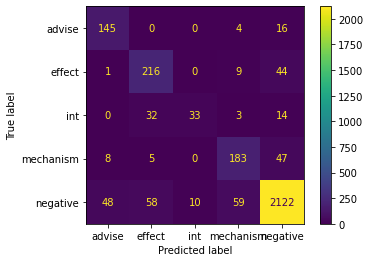

> Epoch INFERENCE
	Loss = 0.00000
TEST
              micro    micro+    binary    advise    effect       int  mechanism  negative
f1_score   0.882892  0.733164  0.903173  0.790191  0.743546  0.528000   0.730539  0.934802
precision  0.882892  0.708845  0.903173  0.717822  0.694534  0.767442   0.709302  0.946054
recall     0.882892  0.759211  0.903173  0.878788  0.800000  0.402439   0.753086  0.923814
____________________________________________________________________________________________________
 test set size = 3057
misclassified  = 358


In [ ]:

# Test
TrainClassificationModel(mode = INFERENCE)
